In [ ]:
import tensorflow as tf
import numpy as np
import random, os, glob, time
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
plt.style.use('dark_background')
sns.set_style("dark")  # Use Seaborn's dark style

plt.rcParams.update({
    'figure.facecolor': '#222222',   # Dark figure background
    'axes.facecolor':   '#222222',     # Dark axes background
    'axes.edgecolor':   'white',       # White axes edges
    'axes.labelcolor':  'white',       # White axis labels
    'xtick.color':      'white',       # White x-tick labels
    'ytick.color':      'white',       # White y-tick labels
    'grid.color':       'white',       # White grid lines (with reduced alpha in plots)
    'text.color':       'white',       # White text
    'legend.frameon':   False,         # No legend frame
    'font.size':        12,
    'axes.labelsize':   14,
    'axes.titlesize':   16,
    'legend.fontsize':  12,
    'xtick.labelsize':  12,
    'ytick.labelsize':  12
})


In [21]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Data and image parameters
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 224, 224, 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
TRAIN_DIR = 'data/chest_xray/chest_xray/train'
TEST_DIR  = 'data/chest_xray/chest_xray/test'
# Assume training folder has one subfolder per class (e.g., NORMAL, PNEUMONIA)
NUM_CLASSES = len([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
# For episodic (few–shot) training:
K_SHOT  = 8  # number of support images per class per episode
Q_QUERY = 8  # number of query images per class per episode

print(f"Found {NUM_CLASSES} classes in training data.")

def load_data_by_class(data_dir):
    """
    Loads file paths for each class into a dictionary.
    """
    data = {}
    for cls in os.listdir(data_dir):
        full_dir = os.path.join(data_dir, cls)
        if os.path.isdir(full_dir):
            files = glob.glob(os.path.join(full_dir, '*'))
            data[cls] = files
    return data


test_data  = load_data_by_class(TEST_DIR)

Found 2 classes in training data.


In [22]:
def generate_episode(data, num_classes=NUM_CLASSES, k_shot=K_SHOT, q_query=Q_QUERY):
    """
    Generate one episode:
      - Randomly sample 'num_classes' from available classes.
      - For each, randomly sample k_shot support images and q_query query images.
    Returns:
      support_images, support_labels, query_images, query_labels, selected_classes.
    """
    support_images, support_labels = [], []
    query_images, query_labels = [], []
    selected_classes = random.sample(list(data.keys()), num_classes)
    for i, cls in enumerate(selected_classes):
        images = random.sample(data[cls], k_shot + q_query)
        support_files = images[:k_shot]
        query_files   = images[k_shot:]
        for img_path in support_files:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = tf.keras.preprocessing.image.img_to_array(img)
            support_images.append(img)
            label = np.zeros(num_classes)
            label[i] = 1
            support_labels.append(label)
        for img_path in query_files:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = tf.keras.preprocessing.image.img_to_array(img)
            query_images.append(img)
            label = np.zeros(num_classes)
            label[i] = 1
            query_labels.append(label)
    # Normalize images:
    support_images = np.array(support_images) / 255.0
    query_images   = np.array(query_images)   / 255.0
    return (support_images, 
            np.array(support_labels, dtype=np.float32), 
            query_images, 
            np.array(query_labels, dtype=np.float32),
            selected_classes)


In [23]:
from tensorflow.keras.models import load_model

# Load the original model
original_model = load_model('models/original_model.h5')

# Load the prototypical backbone model
proto_backbone = load_model('models/proto_backbone.h5')

In [24]:
# ---------------------------
# Evaluation of the Original Model
# ---------------------------
# Create a test data generator (note: images are rescaled)
test_datagen  = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=32, 
    class_mode='categorical',
    shuffle=False)  # shuffle=False to match predictions with true labels

# Measure inference time for the original model:
# --- Apples-to-Apples Inference Time for Original Model ---
# Get the total number of test images from the generator
num_test_images = test_generator.samples

# Run inference on the entire test set and measure total time
t0 = time.time()
orig_preds = original_model.predict(test_generator, steps=len(test_generator), verbose=1)
total_time = time.time() - t0

# Compute the average inference time per image
orig_avg_time_per_image = total_time / num_test_images
print(f"Original Model Total Inference Time: {total_time:.4f} seconds")
print(f"Original Model Average Inference Time per Image: {orig_avg_time_per_image:.6f} seconds")


# Evaluate model performance:
orig_eval = original_model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Original Model Evaluation Metrics:", orig_eval)

# Compute confusion matrix and classification report:
y_pred = np.argmax(orig_preds, axis=1)
y_true = test_generator.classes
cm_orig = confusion_matrix(y_true, y_pred)
report_orig = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()))




print("Confusion Matrix (Original Model):")
print(cm_orig)
print("\nClassification Report (Original Model):")
print(report_orig)



Found 624 images belonging to 2 classes.


/Users/bobbytomlinson/Desktop/Coding/Personal/new/FewShotLearningForPneumonia/pneuFSLvenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step
Original Model Total Inference Time: 66.3749 seconds
Original Model Average Inference Time per Image: 0.106370 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.9098 - loss: 0.5198
Original Model Evaluation Metrics: [0.563895046710968, 0.8942307829856873]
Confusion Matrix (Original Model):
[[213  21]
 [ 45 345]]

Classification Report (Original Model):
              precision    recall  f1-score   support

      NORMAL       0.83      0.91      0.87       234
   PNEUMONIA       0.94      0.88      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.90      0.89       624
weighted avg       0.90      0.89      0.90       624



Found 624 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


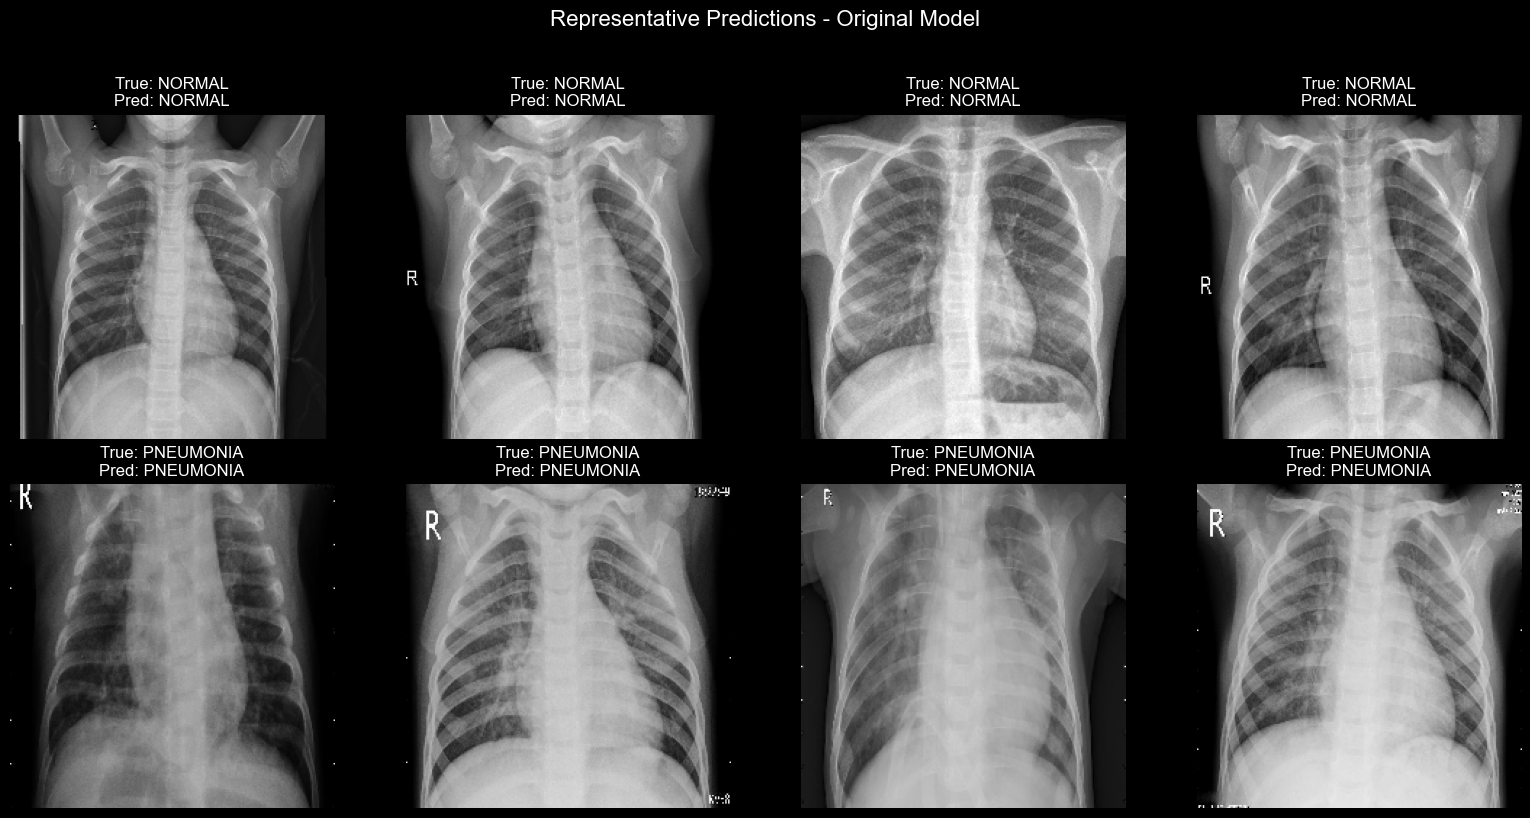

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def visualize_original_model_fixed(original_model, test_dir, img_height=224, img_width=224, max_samples=4):
    """
    Ensures that exactly max_samples examples from each of the two classes ("NORMAL" and "PNEUMONIA")
    are obtained from the test directory, runs inference on them, and visualizes the predictions.
    """
    plt.style.use('dark_background')
    
    # Use a larger batch size to increase chances of getting enough examples
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=64,
        class_mode='categorical',
        shuffle=True
    )
    
    required_classes = ['NORMAL', 'PNEUMONIA']
    # Prepare dictionaries to accumulate images and their true labels
    class_to_images = {cls: [] for cls in required_classes}
    class_to_true = {cls: [] for cls in required_classes}
    
    # Loop over batches until we have at least max_samples for each required class.
    while any(len(class_to_images[cls]) < max_samples for cls in required_classes):
        images, labels = next(test_generator)
        true_indices = np.argmax(labels, axis=1)
        # Mapping from index to class name using the generator's class_indices
        idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
        for i in range(len(images)):
            cls_name = idx_to_class[ true_indices[i] ]
            if cls_name in required_classes and len(class_to_images[cls_name]) < max_samples:
                class_to_images[cls_name].append(images[i])
                class_to_true[cls_name].append(true_indices[i])
    
    # Combine images from both classes in the desired order (e.g. NORMAL first, then PNEUMONIA)
    selected_images = []
    selected_true_labels = []
    for cls in required_classes:
        selected_images.extend(class_to_images[cls][:max_samples])
        selected_true_labels.extend(class_to_true[cls][:max_samples])
    
    selected_images = np.array(selected_images)
    
    # Run inference on the selected images
    preds = original_model.predict(selected_images)
    selected_pred_classes = np.argmax(preds, axis=1)
    
    # Re-create the mapping from index to class name
    idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
    
    # Set up the grid: two rows (one per class) and max_samples columns.
    rows = 2
    cols = max_samples
    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle("Representative Predictions - Original Model", fontsize=16, y=1.02)
    
    # Order the images so that first row is for "NORMAL" and second for "PNEUMONIA"
    # (Assuming test_generator.class_indices gives consistent ordering)
    for i in range(len(selected_images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(selected_images[i])
        true_label_name = idx_to_class[selected_true_labels[i]]
        pred_label_name = idx_to_class[selected_pred_classes[i]]
        plt.title(f"True: {true_label_name}\nPred: {pred_label_name}", fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_original_model_fixed(original_model, TEST_DIR, img_height=224, img_width=224, max_samples=4)


In [ ]:
# ---------------------------
# Evaluation of the Prototypical Network
# ---------------------------
def prototypical_network_prediction(embedding_model, support_imgs, support_lbls, query_imgs, num_classes=NUM_CLASSES):
    support_embeddings = embedding_model(support_imgs)
    query_embeddings   = embedding_model(query_imgs)
    prototypes = []
    for c in range(num_classes):
        class_mask = tf.equal(tf.argmax(support_lbls, axis=1), c)
        class_embeddings = tf.boolean_mask(support_embeddings, class_mask)
        proto = tf.reduce_mean(class_embeddings, axis=0)
        prototypes.append(proto)
    prototypes = tf.stack(prototypes)  # shape: (num_classes, embedding_dim)
    distances = tf.reduce_sum(tf.square(tf.expand_dims(query_embeddings, axis=1) - prototypes), axis=2)
    logits = -distances  # negative Euclidean distance
    predictions = tf.nn.softmax(logits, axis=1)
    return predictions

proto_episodes = 50
total_correct = 0
total_samples = 0
proto_avg_times_per_image = []  # Store average time per image for each episode
episode_accuracies = []

# For aggregating confusion matrix information across episodes:
all_y_true = []
all_y_pred = []

for ep in range(proto_episodes):
    # Generate an episode; unpack all returned values
    s_imgs, s_lbls, q_imgs, q_lbls, selected_classes = generate_episode(test_data)
    
    num_query_images = q_imgs.shape[0]
    # Skip the episode if there are no query images to avoid division by zero.
    if num_query_images == 0:
        print(f"Episode {ep} has no query images; skipping.")
        continue
    
    # Time only the prediction step.
    t0 = time.time()
    proto_preds = prototypical_network_prediction(proto_backbone, s_imgs, s_lbls, q_imgs)
    inference_time_ep = time.time() - t0
    avg_time_ep = inference_time_ep / num_query_images
    proto_avg_times_per_image.append(avg_time_ep)
    
    # Convert predictions and labels to class indices.
    pred_classes = tf.argmax(proto_preds, axis=1).numpy()
    true_classes = tf.argmax(q_lbls, axis=1).numpy()
    
    # Aggregate for overall confusion matrix.
    all_y_true.extend(true_classes.tolist())
    all_y_pred.extend(pred_classes.tolist())
    
    correct = np.sum(pred_classes == true_classes)
    total_correct += correct
    total_samples += num_query_images
    episode_accuracies.append(correct / num_query_images)

# Safeguard in case total_samples is still zero.
if total_samples > 0:
    proto_accuracy = total_correct / total_samples
else:
    proto_accuracy = 0

avg_proto_time_per_image = np.mean(proto_avg_times_per_image) if proto_avg_times_per_image else 0

print("\nPrototypical Network Evaluation:")
print(f"Average Accuracy: {proto_accuracy:.4f}")
print(f"Average Inference Time per Query Image: {avg_proto_time_per_image:.6f} seconds")

# ---------------------------
# Compute Full Confusion Matrix and Classification Report based on all episodes
# ---------------------------
# Note: Ensure that the ordering of classes is consistent across episodes.
# If needed, you may sort the keys in your generate_episode function.
cm_proto_full = confusion_matrix(all_y_true, all_y_pred)
report_proto_full = classification_report(all_y_true, all_y_pred, target_names=selected_classes)

print("\nAggregated Confusion Matrix (Prototypical Network):")
print(cm_proto_full)
print("\nAggregated Classification Report (Prototypical Network):")
print(report_proto_full)



Prototypical Network Evaluation:
Average Accuracy: 0.8538
Average Inference Time per Query Image: 0.278425 seconds

Aggregated Confusion Matrix (Prototypical Network):
[[344  56]
 [ 61 339]]

Aggregated Classification Report (Prototypical Network):
              precision    recall  f1-score   support

      NORMAL       0.85      0.86      0.85       400
   PNEUMONIA       0.86      0.85      0.85       400

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800



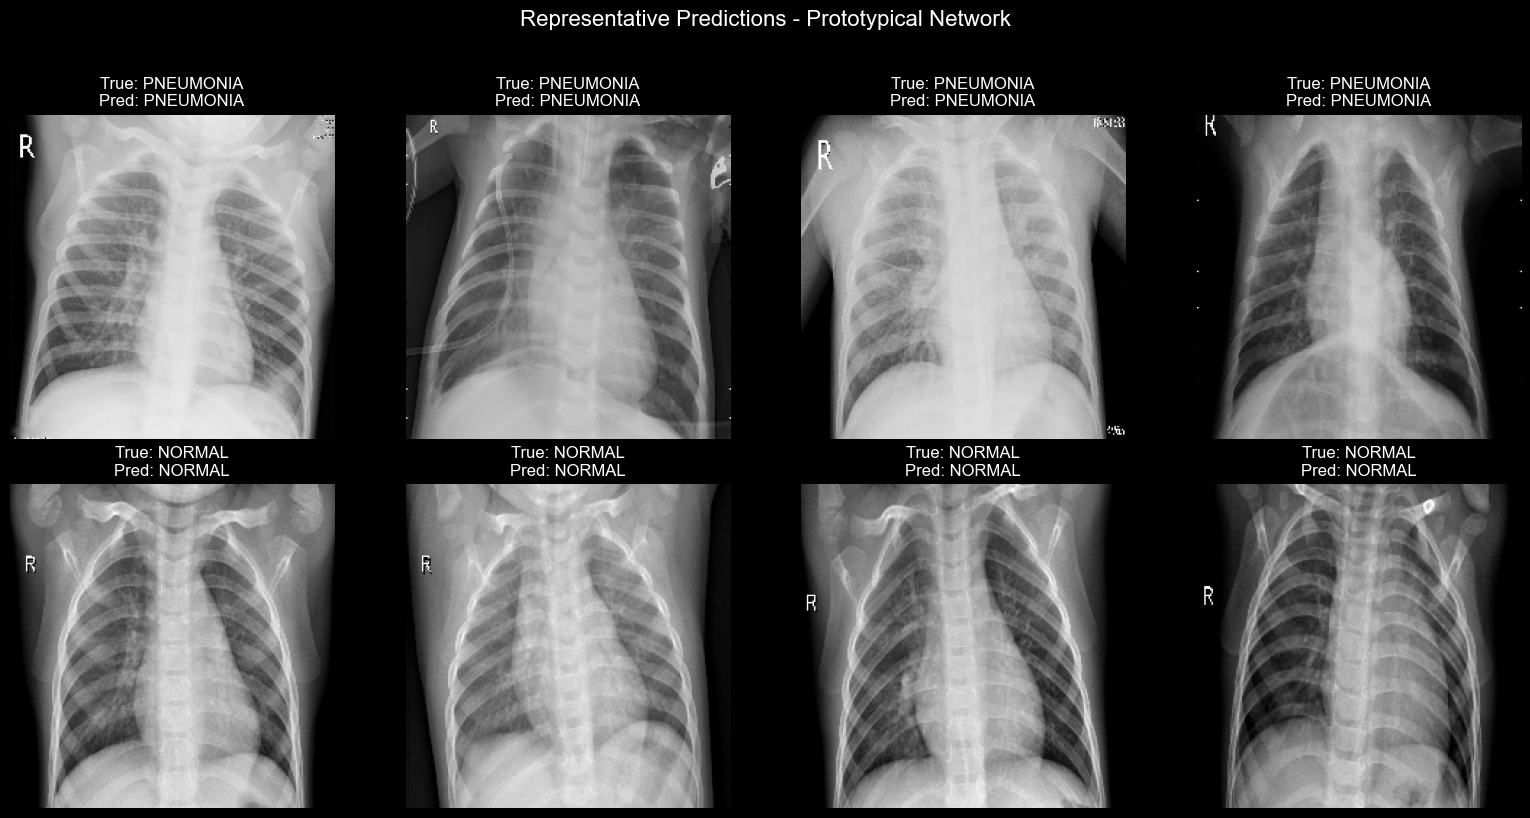

In [27]:
def visualize_proto_model_fixed(proto_backbone, generate_episode, prototypical_network_prediction,
                                test_data, img_height=224, img_width=224, max_samples=4):
    """
    Generates one episode from the test data, then selects exactly max_samples query images
    per class (assumed two classes) for visualization.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import math
    plt.style.use('dark_background')
    
    # Generate one episode; here we assume generate_episode returns:
    # (support_images, support_labels, query_images, query_labels, selected_classes)
    s_imgs, s_lbls, q_imgs, q_lbls, selected_classes = generate_episode(test_data)
    
    # Run inference on all query images in the episode
    proto_preds = prototypical_network_prediction(proto_backbone, s_imgs, s_lbls, q_imgs)
    pred_classes = tf.argmax(proto_preds, axis=1).numpy()
    true_classes = tf.argmax(q_lbls, axis=1).numpy()
    
    # For each class (here assumed order in selected_classes, e.g. index 0 and 1), select exactly max_samples images.
    n_classes = len(selected_classes)  # assumed to be 2 ("NORMAL" and "PNEUMONIA")
    selected_indices = []
    for class_idx in range(n_classes):
        indices = np.where(true_classes == class_idx)[0]
        if len(indices) >= max_samples:
            selected_indices.extend(indices[:max_samples])
        else:
            # If by any chance there aren't enough examples (should not happen if Q_QUERY >= max_samples)
            selected_indices.extend(indices)
    
    # Reorder indices so that images from the same class are together: first row for class index 0, second row for index 1.
    class0_indices = [i for i in selected_indices if true_classes[i] == 0][:max_samples]
    class1_indices = [i for i in selected_indices if true_classes[i] == 1][:max_samples]
    ordered_indices = class0_indices + class1_indices  # total should be 2 * max_samples
    
    # Set up the grid: two rows, max_samples columns.
    rows = n_classes
    cols = max_samples
    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle("Representative Predictions - Prototypical Network", fontsize=16, y=1.02)
    
    for i, idx in enumerate(ordered_indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(q_imgs[idx])
        true_name = selected_classes[ true_classes[idx] ]
        pred_name = selected_classes[ pred_classes[idx] ]
        plt.title(f"True: {true_name}\nPred: {pred_name}", fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_proto_model_fixed(proto_backbone, generate_episode, prototypical_network_prediction, test_data, img_height=224, img_width=224, max_samples=4)


In [ ]:
# Build a summary dictionary using our updated variables:
# - orig_eval[1] is the overall test set accuracy for the original model.
# - proto_accuracy is the average accuracy from our episodes for the prototypical network.
# - orig_avg_time_per_image is the average inference time per image for the original model.
# - avg_proto_time_per_image is the average inference time per query image for the prototypical network.
metrics_summary = {
    "Method": ["Original Model", "Prototypical Network"],
    "Accuracy": [orig_eval[1], proto_accuracy],
    "Average Inference Time per Image (s)": [orig_avg_time_per_image, avg_proto_time_per_image]
}

df_metrics = pd.DataFrame(metrics_summary)
print("\n=== Summary Metrics ===")
print(df_metrics)

# Optionally, export metrics to CSV for further reporting:
df_metrics.to_csv("evaluation_summary.csv", index=False)
print("\nExported evaluation metrics to evaluation_summary.csv")



=== Summary Metrics ===
                 Method  Accuracy  Average Inference Time per Image (s)
0        Original Model  0.894231                              0.106370
1  Prototypical Network  0.853750                              0.278425

Exported evaluation metrics to evaluation_summary.csv


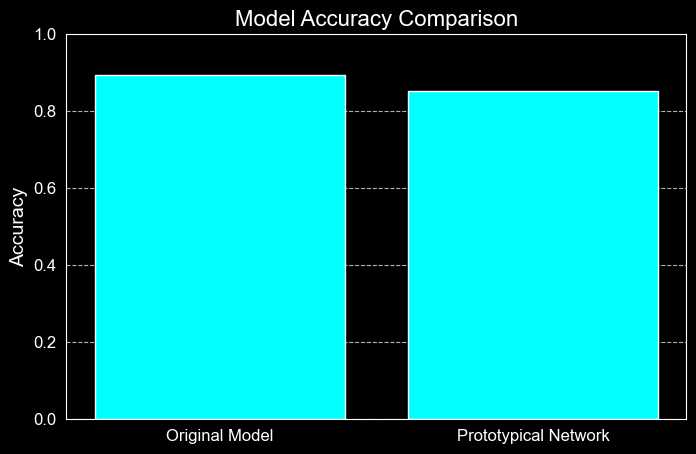

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(df_metrics["Method"], df_metrics["Accuracy"], color='cyan')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

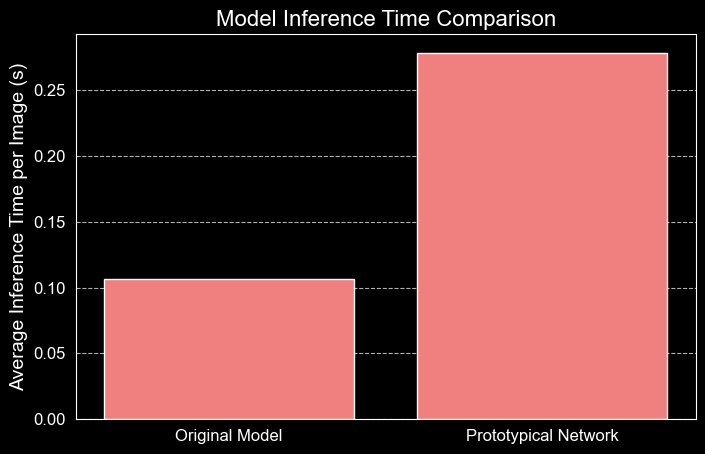

In [30]:
plt.figure(figsize=(8, 5))
plt.bar(metrics_summary["Method"], metrics_summary["Average Inference Time per Image (s)"], color='lightcoral')
plt.ylabel("Average Inference Time per Image (s)")
plt.title("Model Inference Time Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

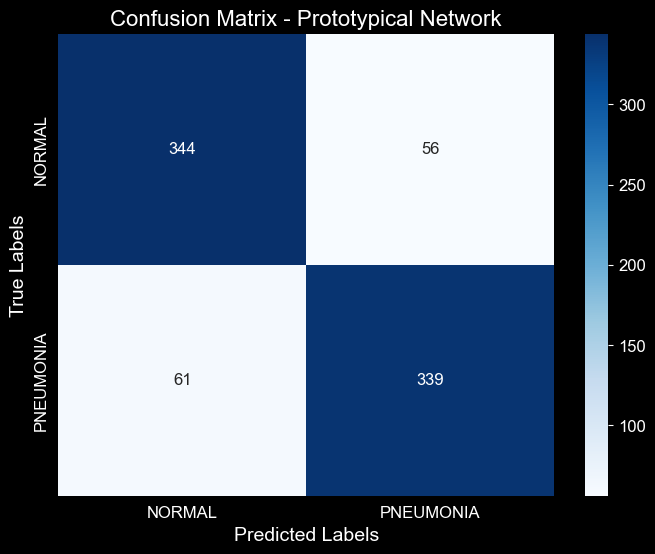

In [ ]:
# Create a heatmap of the confusion matrix for the Original Model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_proto_full, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Prototypical Network')
plt.show()


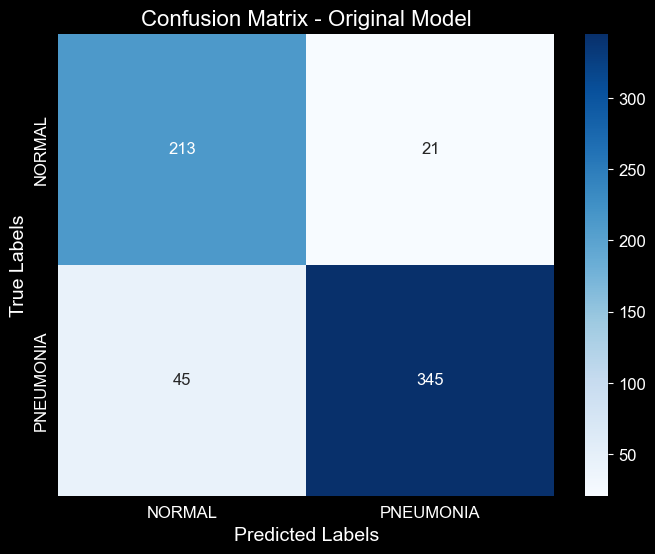

In [ ]:
# Create a heatmap of the confusion matrix for the Original Model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Original Model')
plt.show()


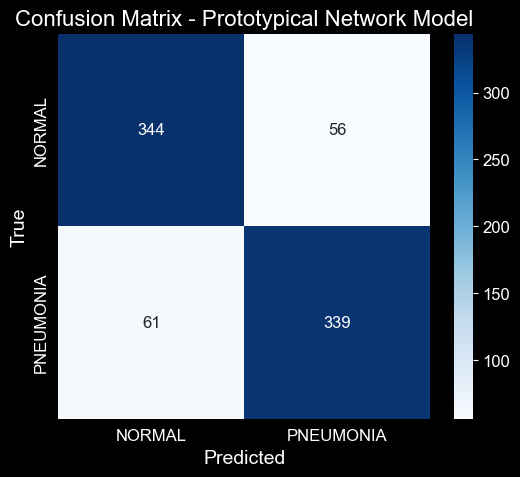

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_proto_full, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Prototypical Network Model')
plt.show()


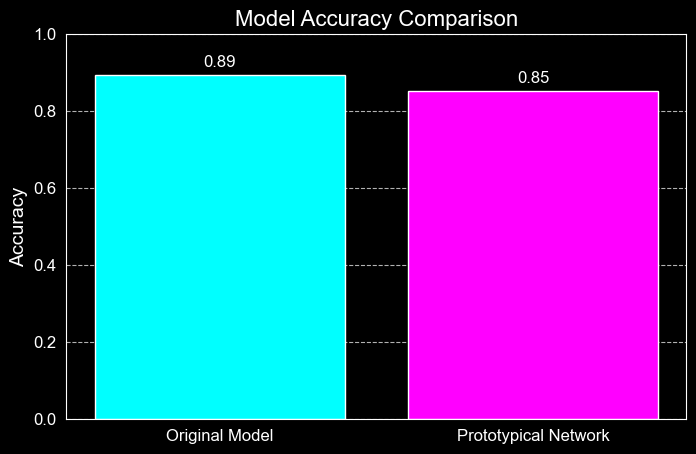

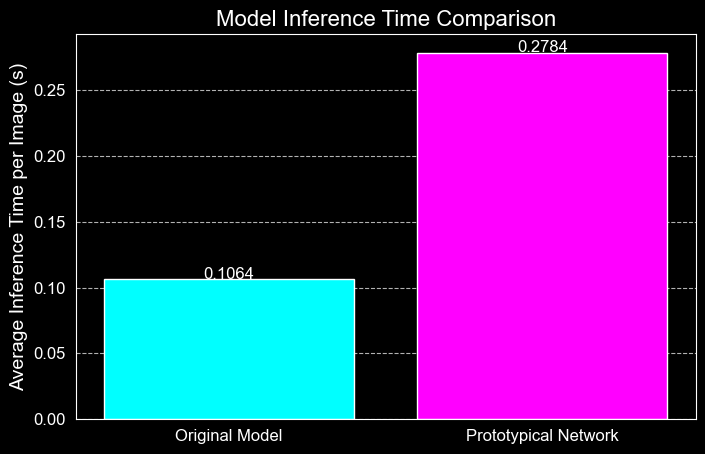

In [ ]:
# Define key metrics (using your variables computed earlier)
methods = ['Original Model', 'Prototypical Network']
accuracy = [orig_eval[1], proto_accuracy]  # orig_eval[1] holds the test accuracy of the original model
inference_time = [orig_avg_time_per_image, avg_proto_time_per_image]

# Create a DataFrame for easy plotting
df_metrics = pd.DataFrame({
    'Method': methods,
    'Accuracy': accuracy,
    'Inference Time (s)': inference_time
})

# ----- Plot 1: Accuracy Comparison -----
plt.figure(figsize=(8, 5))
plt.bar(df_metrics['Method'], df_metrics['Accuracy'], color=['cyan', 'magenta'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
for index, value in enumerate(df_metrics['Accuracy']):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', fontsize=12)
plt.show()

# ----- Plot 2: Inference Time Comparison -----
plt.figure(figsize=(8, 5))
plt.bar(df_metrics['Method'], df_metrics['Inference Time (s)'], color=['cyan', 'magenta'])
plt.ylabel('Average Inference Time per Image (s)')
plt.title('Model Inference Time Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for index, value in enumerate(df_metrics['Inference Time (s)']):
    plt.text(index, value + 0.0005, f"{value:.4f}", ha='center', fontsize=12)
plt.show()
